# 🕵🏼 **6. Óra:** Lineáris rendszer szabályozása

## 🎯 Küldetés  

- Ismétlés (diszkrét deriválás és trapéz módszer)
- Bevezetés a PID szabályozásba
- Szabályozási feladat megoldása

---

## Hasznos linkek  
🔍 [Lényegretörő bevezetés a PID szabályozásba](https://www.youtube.com/watch?v=UR0hOmjaHp0) 

🔍 [Egy egyszerű példa](https://www.youtube.com/watch?v=XfAt6hNV8XM)

## Ismétlés

### Deriválás diszkrét időben
Legyen $ x[n] $ egy diszkrét időben definiált jel, és legyen $ \Delta t $ a mintavételezési idő. A diszkrét időbeli derivált vagy különbségi hányados a következőképpen definiálható:

$$
x'[n] = \frac{x[n] - x[n-1]}{\Delta t}
$$

A már jól ismért differencia számító függvényt fogjuk alkalmazni:
```python
def deriv(function, time_step):
    derivative = []
    for i in range(1, len(function)):
        derivative.append((function[i] - function[i-1]) / time_step)
    return derivative
```

### Numerikus integrálás trapéz módszerrrel
Az interpoláló függvény egy egyenes vonal lehet (azaz egy 1-es fokú polinom), amely áthalad az $ (a, f(a)) $ és $ (b, f(b)) $ pontokon. Ezt hívjuk **trapéz szabálynak**, amely a következőképpen van megadva:

$$
\int_a^b f(x) \, dx \approx (b - a) \left( \frac{f(a) + f(b)}{2} \right)
$$

<center>
  <img src="Integration_trapezoid.png" width="500" style="background-color: white;" />
</center>

Ezt már megtanultuk korábban implementálni a következő módon, egység hosszú intervallumok esetén:
```python
def trapezoidal_integral(function, time_step):
    integral = [0]
    comulative_sum = 0
    for i in range(1, len(function)):
        comulative_sum += time_step * (function[i-1] + function[i]) / 2
        integral.append(comulative_sum)
    return integral
```

## Bevezetés a PID szabályozásba

A PID (Arányos-Integráló-Deriváló) szabályozó az egyik legelterjedtebb szabályozási módszer az iparban és a mérnöki gyakorlatban. Alapelve, hogy a rendszer **eltérését** (hibáját) a kívánt, ún. **referencia értéktől** három komponens segítségével kompenzálni tudjuk, így a számunkra megfelelő állapotba juttatva a rendszert:  

1. **Arányos (P) tag:** A jelenlegi hibaérték alapján határozza meg a szabályozó válaszát. Minél nagyobb az eltérés, annál nagyobb a beavatkozás.
2. **Integráló (I) tag:** A múltbeli hibák összegzésével korrigálja az esetleges állandósult hibát.
3. **Deriváló (D) tag:** A hiba változási sebessége alapján reagál, csökkentve a túllövést és a rendszer ingadozását.

A PID szabályozó kimenete az alábbi egyenlet szerint számítható, ez lesz a beavatkozó jelünk, amit kiadunk a rendszerre:  

$$
u(t) = K_p e(t) + K_i \int e(t) dt + K_d \frac{de(t)}{dt}
$$

ahol:  
- $ e(t) $ a hiba (az eltérés a kívánt értéktől),  
- $ K_p $, $ K_i $ és $ K_d $ a szabályozó erősítési tényezői (súlyok), ezeket mi hangoljuk be, hogy elérjük a kívánt viselkedést.

<center>
  <img src="PID_control.png" width="500" style="background-color: white;" />
</center>

### A PID szabályozás előnyei
- Képes minimalizálni a szabályozási hibát.
- Rugalmas és sokféle rendszerhez alkalmazható.
- Az integráló tag kiküszöböli az állandósult hibát, míg a deriváló tag csökkenti az ingadozást (túllövést).

### Hol használják?
A PID szabályozót széles körben alkalmazzák például:
- Robotkarok pozíciószabályozásában,
- Hőmérséklet-szabályozásban,
- Motorok fordulatszám-szabályozásában,
- Drónok egyensúlyozásában.


## Első szabályozási feladatunk: inverz inga

<center>
  <img src="pendulum.png" width="500" style="background-color: white;" />
</center>

🔍 [Inverz inga szimulátor](https://codepen.io/oscarsaharoy/full/LYbmVma)

### Importok

In [41]:
import numpy as np
import matplotlib.pyplot as plt

### Az ismerős függvények

In [42]:
def deriv(function, time_step):
    derivative = []
    for i in range(1, len(function)):
        derivative.append((function[i] - function[i-1]) / time_step)
    return derivative

def trapezoidal_integral(function, time_step):
    integral = [0]
    cumulative_sum = 0
    for i in range(1, len(function)):
        cumulative_sum += time_step * (function[i-1] + function[i]) / 2
        integral.append(cumulative_sum)
    return integral

In [43]:
# Rendszerparaméterek
dt = 0.02  # Időlépés [s]
g = 9.81   # Gravitáció [m/s^2]
l = 0.5    # Inga hossza [m]
m = 0.1    # Inga tömege [kg]
M = 1.0    # Kocsi tömege [kg]
b = 0.1    # Súrlódás [N]

# Erősítési tényezők
Kp = 50
Ki = 5
Kd = 10 

# Szimuláció init
T = 5  # 5 másodpercig fog futni az egész
N = int(T / dt) # Ennyi darab lépés lesz

# Kezdeti feltételek (differenciálegyenlet esetén ezekre szükség van)
theta = np.pi + 0.1  # Eredeti pozíciója az ingának
theta_dot = 0 # Kezdeti szögsebesség
x = 0  # Kocsi pozíciója
x_dot = 0  # Kocsi sebessége

# Tömbök létrehozása az adatok tárolásához
theta_list = [theta] # valós theta értékek
theta_dot_list = [theta_dot] # szögsebességek tárolása
error_list = [theta - np.pi]  # (valós theta - referencia theta, azt szeretném, hogy egyenesen álljon)
control_list = [0]  # Beavatkozó jelet fogjuk itt tárolni minden időpillanatban (erő)

#### A szimulációban a következő mozgásegyenleteket fogjuk használni:
1. **Newton 2. törvénye**:
$$
F = M \ddot{x} \Rightarrow \ddot{x} = \frac{F}{M}
$$
Mivel nekünk van surlódásunk is, a külső erő $ F = u - b\dot{x} $ a beavatkozó jel (erő) és a súrlódási erő különbsége lesz, így jön ki a gyorsulásra rendezve a következő egyenlet:
$$
\ddot{x} = \frac{u - b\dot{x}}{M}
$$
2. **Az inverz inga szöggyorsulásának egyenlete**:
$$
\ddot{\theta} = \frac{g}{l} \sin{\theta} + \frac{\ddot{x}}{l} \cos{\theta}
$$
Ez az inga végének forgómozgását írja le, ahol:
- $ \theta $ az inga szöge a függőlegeshez képest,
- $ \dot{\theta} $ az inga szögsebessége,
- $ \ddot{\theta} $ az inga szöggyorsulása,
- $ g $ a gravitációs gyorsulás,
- $ l $ az inga hossza,
- $ \ddot{x} $ a kocsi gyorsulása.

Az egyenlet a következő két részből áll:
- Az **első tag** $ \frac{g}{l} \sin{\theta} $ a gravitációs nyomaték hatását írja le, amely az ingát a stabil egyensúlyi helyzetbe (lefelé) húzza.
- A **második tag** $ \frac{\ddot{x}}{l} \cos{\theta} $ azt mutatja, hogy a kocsi gyorsulása hogyan befolyásolja az inga mozgását.


### Integrálás Euler módszerrel (numerikus módszer)
Az Euler-módszer egy egyszerű numerikus technika, amelyet a differenciálegyenletek (ODE-k) megoldásának közelítésére használnak. A módszer a függvény deriváltját a jelenlegi időpontban közelíti, és ezt használja a függvény következő időpontban való értékének becslésére.

#### Lényeg:

Tegyük fel, hogy van egy differenciálegyenletünk:

$$
\frac{dy}{dt} = f(t, y)
$$

Ahol:
- $ y(t) $ az a függvény, amit meg akarunk találni,
- $ f(t, y) $ függvény az $ y(t) $ deriváltja az idő szerint (azaz a $ y $ változásának üteme).

Az Euler-módszer a következőképp közelíti $ y(t) $ jövőbeli értékét $ t + \Delta t $ időpontban:

$$
y(t + \Delta t) = y(t) + \Delta t \cdot f(t, y(t))
$$

Ahol:
- $ y(t) $ a függvény aktuális értéke,
- $ \Delta t $ az időlépés,
- $ f(t, y(t)) $ az aktuális időpontban vett derivált.

### A szimuláció:

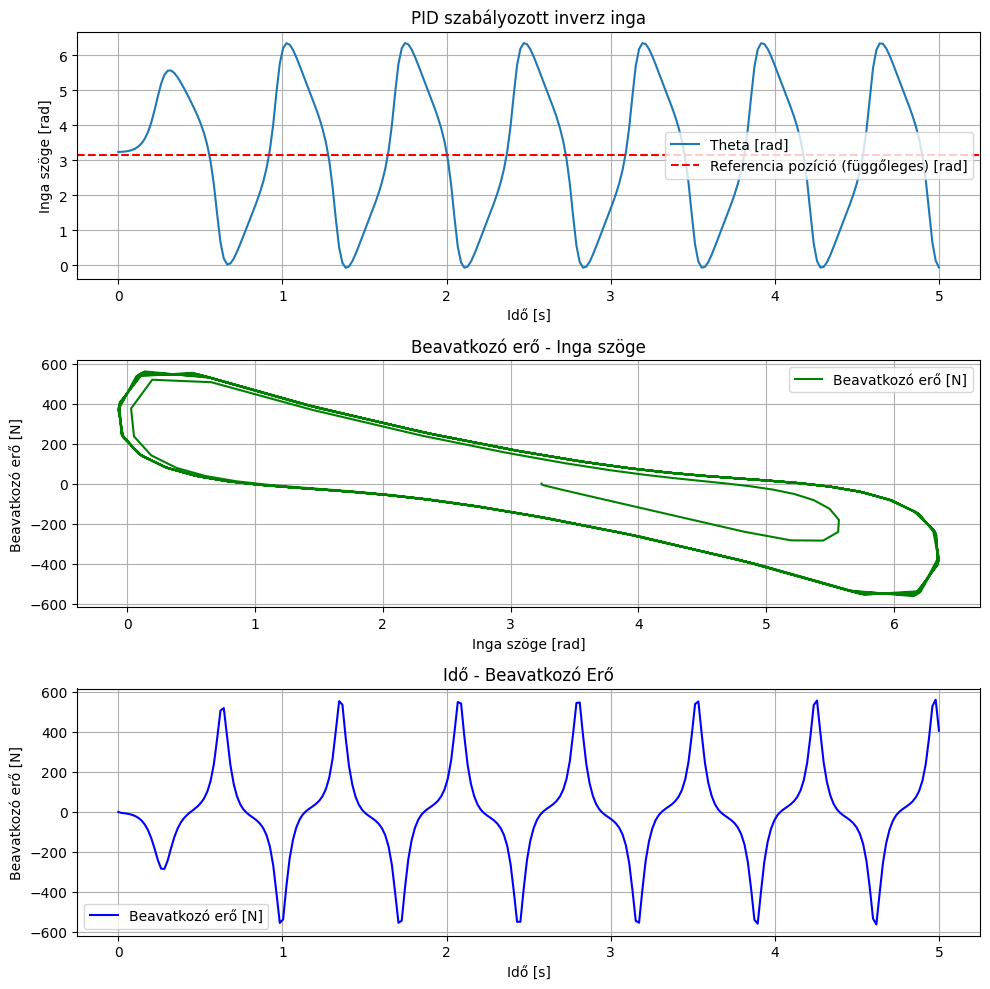

In [ ]:
for _ in range(0,(N - 1)):
    error = theta_list[-1] - np.pi
    error_list.append(error)
 
    # Erősítési tényezők számítása adott mintavételi pontban
    P_term =
    I_term =
    D_term =
    
    # Beavatkozó jel (erő) számítása
    u = # "Ellen kell tartani" a hibának
    control_list.append(u)

    # Kocsi gyorsulása
    x_ddot = 

    # Inga szöggyorsulása
    theta_ddot = 

    # Integrálás Euler módszerrel, adott időpillanatban ezeket is számítanunk kell
    theta_dot += 
    theta += 
    x_dot += 
    x +=

    # Adatok eltárolása a tömbjeinkben
    theta_list.append(theta)
    theta_dot_list.append(theta_dot)


# Plotolás
time_axis = np.linspace(0, T, N)

plt.figure(figsize=(10, 10))

# 1.
plt.subplot(3, 1, 1)
plt.plot(time_axis, theta_list, label="Theta [rad]")
plt.axhline(y=np.pi, color='r', linestyle='--', label="Referencia pozíció (függőleges) [rad]")
plt.xlabel("Idő [s]")
plt.ylabel("Inga szöge [rad]")
plt.title("PID szabályozott inverz inga")
plt.legend()
plt.grid()

# 2.
plt.subplot(3, 1, 2)
plt.plot(theta_list, control_list, label="Beavatkozó erő [N]", color='g')
plt.xlabel("Inga szöge [rad]")
plt.ylabel("Beavatkozó erő [N]")
plt.title("Beavatkozó erő - Inga szöge")
plt.legend()
plt.grid()

# 3.
plt.subplot(3, 1, 3)
plt.plot(time_axis, control_list, label="Beavatkozó erő [N]", color='b')
plt.xlabel("Idő [s]")
plt.ylabel("Beavatkozó erő [N]")
plt.title("Idő - Beavatkozó Erő")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()